In [ ]:
from google.colab import drive
drive.mount('/content/drive',  force_remount=True)

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/LLM - Detect AI Generated Text')

In [ ]:
!pip install -q -U peft
!pip install -q -U accelerate
!pip install -q -U bitsandbytes
!pip install -q -U transformers
!pip install -q -U sentencepiece
!pip install -q -U datasets
!pip install -q -U trl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.7/174.7 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 520.4/520.4 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━

In [ ]:
!huggingface-cli login --token=hf_YejOqZMqFaOi

Token will not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [ ]:
from __future__ import annotations

TARGET_MODEL = "meta-llama/Llama-2-7b-hf"

DEBUG = False

In [ ]:
from transformers import AutoTokenizer, LlamaForSequenceClassification
from trl import SFTTrainer, DataCollatorForCompletionOnlyLM
import pandas as pd
tokenizer = AutoTokenizer.from_pretrained(TARGET_MODEL, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.10/dist-packages/trl/trainer/ppo_config.py:141: UserWarning: The `optimize_cuda_cache` arguement will be deprecated soon, please use `optimize_device_cache` instead.
  warnings.warn(


(…)7b-hf/resolve/main/tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

(…)-hf/resolve/main/special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

(…)lama-2-7b-hf/resolve/main/tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

In [ ]:
# %% Directory settings

# ====================================================
# Directory settings
# ====================================================
from pathlib import Path

OUTPUT_DIR = Path("./model_output_fold_0")
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

INPUT_DIR = Path("./")

In [ ]:
train_data_0 = pd.read_csv("train_drcat_04.csv")
train_data_0 = train_data_0[train_data_0["label"]==1]
train_data_0 = train_data_0[["text","label"]]
train_data_0['text'] = train_data_0['text'].str.replace('\n', '')

In [ ]:
train_data_1 = pd.read_csv("daigt_external_dataset.csv", sep=',')
train_data_1 = train_data_1.rename(columns={'generated': 'label'})
train_data_1 = train_data_1[["source_text"]]
train_data_1.columns = ["text"]
train_data_1['text'] = train_data_1['text'].str.replace('\n', '')
train_data_1["label"] = 1

In [ ]:
train_data_2 = pd.read_csv("train_essays_RDizzl3_seven_v1.csv")

In [ ]:
train_df = pd.concat([train_data_0, train_data_1, train_data_2])
train_df.reset_index(inplace=True, drop=True)
print(f"Train dataframe has shape: {train_df.shape}")
train_df.head()

Train dataframe has shape: (32706, 2)


,text,label
0,"In recent years, technology has had a profoun...",1
1,I strongly believe that meditation and mindful...,1
2,One way school administrators can attempt to c...,1
3,While summer is meant as a break from the regu...,1
4,The use of Facial Action Coding System (FACS) ...,1


<Axes: >

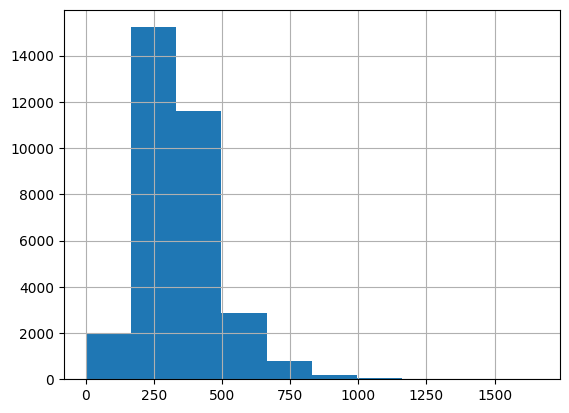

In [ ]:
train_df['text_length'] = train_df['text'].apply(lambda x:len(x.split()))
train_df['text_length'].hist()

In [ ]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
X = train_df.loc[:, train_df.columns != "label"]
y = train_df.loc[:, train_df.columns == "label"]

for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    train_df.loc[valid_index, "fold"] = i

print(train_df.groupby("fold")["label"].value_counts())
train_df.head()

fold  label
0.0   1        3692
      0        2850
1.0   1        3691
      0        2850
2.0   1        3691
      0        2850
3.0   1        3691
      0        2850
4.0   1        3691
      0        2850
Name: label, dtype: int64


,text,label,text_length,fold
0,"In recent years, technology has had a profoun...",1,250,1.0
1,I strongly believe that meditation and mindful...,1,328,0.0
2,One way school administrators can attempt to c...,1,185,2.0
3,While summer is meant as a break from the regu...,1,281,3.0
4,The use of Facial Action Coding System (FACS) ...,1,263,1.0


In [ ]:
# fold0 as valid
valid_df = train_df[train_df["fold"] == 0]
train_df = train_df[train_df["fold"] != 0]


In [ ]:
from transformers import TrainingArguments, Trainer

In [ ]:
# load model with 4bit bnb

from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType # type: ignore
from transformers import BitsAndBytesConfig
import torch

peft_config = LoraConfig(
    r=64,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    target_modules=[
        "q_proj",
        "v_proj"
    ],
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

#bnb_config = BitsAndBytesConfig(load_in_8bit=True)


In [ ]:
base_model = LlamaForSequenceClassification.from_pretrained(
    TARGET_MODEL,
    num_labels=2,
    quantization_config=bnb_config,
    device_map={"":0}
)
base_model.config.pretraining_tp = 1 # 1 is 7b
base_model.config.pad_token_id = tokenizer.pad_token_id

(…)a/Llama-2-7b-hf/resolve/main/config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

(…)esolve/main/model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model = get_peft_model(base_model, peft_config)

In [ ]:
model.print_trainable_parameters()

trainable params: 33,562,624 || all params: 6,640,914,432 || trainable%: 0.5053916044795681


In [ ]:
# debug
if DEBUG:
    train_df = train_df.sample(300)
    valid_df = valid_df.sample(50)
#train_df = train_df.sample(100)
#valid_df = valid_df.sample(30)
print(train_df.label.value_counts(), valid_df.label.value_counts())

1    14764
0    11400
Name: label, dtype: int64 1    3692
0    2850
Name: label, dtype: int64


In [ ]:
# datasets
from datasets import Dataset

# from pandas
train_ds = Dataset.from_pandas(train_df)
valid_ds = Dataset.from_pandas(valid_df)

#test_ds = Dataset.from_pandas(test_df)

In [ ]:
def preprocess_function(examples, max_length=1024):
    return tokenizer(examples["text"], truncation=True, max_length=max_length, padding=True)

In [ ]:
train_tokenized_ds = train_ds.map(preprocess_function, batched=True)
valid_tokenized_ds = valid_ds.map(preprocess_function, batched=True)
#test_tokenized_ds = test_ds.map(preprocess_function, batched=True)



Map:   0%|          | 0/26164 [00:00<?, ? examples/s]

Map:   0%|          | 0/6542 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding="longest")

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    accuracy_val = accuracy_score(labels, predictions)
    roc_auc_val = roc_auc_score(labels, predictions)

    return {
        "accuracy": accuracy_val,
        "roc_auc": roc_auc_val,
    }


In [ ]:
steps = 5 if DEBUG else 20

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=5e-5,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=16,
    max_grad_norm=0.3,
    optim='paged_adamw_32bit',
    lr_scheduler_type="cosine",
    num_train_epochs=1,
    weight_decay=0.01,
    evaluation_strategy="steps",
    save_strategy="steps",
    load_best_model_at_end=True,
    push_to_hub=False,
    warmup_steps=steps,
    eval_steps=steps,
    logging_steps=steps,
    report_to='none' # if DEBUG else 'wandb',
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_ds,
    eval_dataset=valid_tokenized_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Roc Auc
20,0.761700,0.479004,0.792418,0.783720
40,0.255200,0.077454,0.971874,0.973321
60,0.031600,0.020386,0.993274,0.992721
80,0.029300,0.011391,0.996943,0.996891
100,0.025100,0.008369,0.997707,0.997608
120,0.037000,0.012566,0.995567,0.994952
140,0.001200,0.005905,0.997860,0.997744
160,0.004900,0.004154,0.998319,0.998150
180,0.011700,0.003500,0.998624,0.998421
200,0.001400,0.004833,0.997860,0.997544


Step,Training Loss,Validation Loss,Accuracy,Roc Auc
20,0.761700,0.479004,0.792418,0.783720
40,0.255200,0.077454,0.971874,0.973321
60,0.031600,0.020386,0.993274,0.992721
80,0.029300,0.011391,0.996943,0.996891
100,0.025100,0.008369,0.997707,0.997608
120,0.037000,0.012566,0.995567,0.994952
140,0.001200,0.005905,0.997860,0.997744
160,0.004900,0.004154,0.998319,0.998150
180,0.011700,0.003500,0.998624,0.998421
200,0.001400,0.004833,0.997860,0.997544


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-26-15723f724764>", line 34, in <cell line: 34>
    trainer.train()
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1555, in train
    return inner_training_loop(
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 1922, in _inner_training_loop
    self._maybe_log_save_evaluate(tr_loss, model, trial, epoch, ignore_keys_for_eval)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2282, in _maybe_log_save_evaluate
    self._save_checkpoint(model, trial, metrics=metrics)
  File "/usr/local/lib/python3.10/dist-packages/transformers/trainer.py", line 2350, in _save_checkpoint
    self.save_model(output_dir, _internal_call=True)
  File "/usr/local/lib/python3.10/dist-packages/transformers/train

In [ ]:
from shutil import rmtree

trainer.save_model(output_dir=str(OUTPUT_DIR))

for path in Path(training_args.output_dir).glob("checkpoint-*"):
    if path.is_dir():
        rmtree(path)

In [ ]:
del trainer, model, base_model

In [ ]:
# cuda cache clear
import torch
torch.cuda.empty_cache()

In [ ]:
# load model / tokenizer with 4bit bnb

from peft import get_peft_config, PeftModel, PeftConfig, get_peft_model, LoraConfig, TaskType # type: ignore
from transformers import BitsAndBytesConfig
import torch


bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16
)

In [ ]:
from transformers import AutoTokenizer, LlamaForSequenceClassification

base_model = LlamaForSequenceClassification.from_pretrained(
    TARGET_MODEL,
    num_labels=2,
    quantization_config=bnb_config,
    device_map={"":0}
)
base_model.config.pretraining_tp = 1 # 1 is 7b
base_model.config.pad_token_id = tokenizer.pad_token_id


In [ ]:
OUTPUT_DIR

In [ ]:
model = PeftModel.from_pretrained(base_model, str(OUTPUT_DIR))

In [ ]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

In [ ]:
pred_output = trainer.predict(valid_tokenized_ds)
logits = pred_output.predictions

In [ ]:
# from scipy.special import expit as sigmoid
import numpy as np
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
probs = sigmoid(logits[:, 1])
probs.shape, probs[0:5]

In [ ]:
sub = pd.DataFrame()
sub['id'] = valid_df['id']
sub['generated'] = probs
# sub.to_csv('submission.csv', index=False)
sub.head()

In [ ]:
pred_output = trainer.predict(test_tokenized_ds)
logits = pred_output.predictions
probs = sigmoid(logits[:, 1])
probs